In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import os
import random
import PIL.Image
import numpy as np
from fastai.vision import *
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET
from fastai.metrics import error_rate

## Dataset Variables

In [10]:
dataset_path = "/src/users/Kevin/UTKinect"
folders = ["depth","rgb"]
label_fname = "actionLabel.txt"

In [11]:
data_dict = {"depth":[],"rgb":[],"labels":[],"rgbd":[]}
# For reference: 
DATA_SIZE = 5865

## Helper Functions For Loading Images From Folder

In [12]:
def string_Arr_to_float(str_arr):
    """
    func: convert all string numbers in list to float
    param:  list of string numbers
    out:  list of float numbers
    """
    for x in range(len(str_arr)):
        str_arr[x] = float(str_arr[x])
    return str_arr

In [13]:
def depth_xml_to_arr(imgFilePath, depthFilePath,beginFrm, endFrm, label):
    """
    func: load depth image data from given range of frames, and append label
    param: depthFilePath - path to file where frames are found
           beginFrm - first frame of activty 
           endFrm - last frame of activty
           label - label of activity
    out: list of touples contatining depth data of each frame between beginFrm and endFrm and label
    """  
    xmlFiles = [f for f in os.listdir(depthFilePath) if f.endswith('.xml')]
    xmlFiles.sort(key=lambda item: (len(item), item))
    
    depthSequence = [[],[]]
    
    beginFrmFile = "depthImg%i.xml" %beginFrm
    endFrmFile = "depthImg%i.xml" %endFrm
    
    beginIdx = xmlFiles.index(beginFrmFile)
    endIdx = xmlFiles.index(endFrmFile)
    useXmlFiles = xmlFiles[beginIdx:endIdx+1]
    
    for xmlFile in useXmlFiles:
        imgFile = xmlFile.replace("depthImg","colorImg").replace(".xml",".jpg")
        img = PIL.Image.open(os.path.join(imgFilePath, imgFile))
        
        tree = ET.parse(os.path.join(depthFilePath, xmlFile))
        filename, _ = os.path.splitext(xmlFile)
        elem = tree.find('%s/data' % filename)
        strData = elem.text
        str_Arr = strData.split()
        floatData = string_Arr_to_float(str_Arr)
        arr = np.array(floatData)
        depthData = np.array(floatData).reshape(240, 320)
        
        img = img.resize((320,240))
        rgb = np.array(img)
        
        data_dict["rgb"].append(rgb)
        data_dict["depth"].append(depthData)
        data_dict["labels"].append(label)
        #data_dict["rgbd"].append(np.concatenate((rgb, depthData), axis = 2))

In [14]:
def load_depth_imgs(img_path,depth_path,label_fname):
    """
    func: load depth image data from xml file
    param: depth_path - path to folder with depth data
           label_fname - name of the label txt file
    out: list of touples with depth img and activity label
    """    
    configFile = os.path.join(dataset_path, label_fname)
    with open(configFile, "r") as f:
        lines = f.read().splitlines()

    for i in range(0,220,11):
        currLines = lines[i:i+11]
        depthFileDir = currLines[0]

        print("loading %s" %depthFileDir)
        for line in currLines[1:]:
                splitIdx = line.index(":")
                label = line[:splitIdx]
                nums = line[splitIdx+1:].split()
                beginFrm = int(nums[0])
                endFrm = int(nums[1])
                
                depthFilePath = os.path.join(depth_path,depthFileDir)
                imgFilePath = os.path.join(img_path,depthFileDir)
                
                depth_xml_to_arr(imgFilePath, depthFilePath,beginFrm, endFrm, label)
    
    print("loading complete!")

## Load Data  

In [15]:
depth_path = dataset_path + "/depth"
img_path = dataset_path + "/RGB"
load_depth_imgs(img_path,depth_path,label_fname)

loading s01_e01
loading s01_e02
loading s02_e01
loading s02_e02
loading s03_e01
loading s03_e02
loading s04_e01
loading s04_e02
loading s05_e01
loading s05_e02
loading s06_e01
loading s06_e02
loading s07_e01
loading s07_e02
loading s08_e01
loading s08_e02
loading s09_e01
loading s09_e02
loading s10_e01
loading s10_e02
loading complete!


In [16]:
len(data_dict["rgb"])

5865

### Load Images To Torch

In [17]:
depthData = torch.from_numpy(np.array(data_dict['depth'])).permute(0,1,2).type(torch.FloatTensor)
depthData = depthData[:,None,:,:]

In [18]:
imageData = torch.from_numpy(np.array(data_dict['rgb'])).permute(0,3,1,2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fee4bbba190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fee4bdb4fa0>)

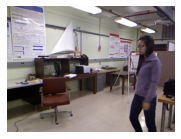

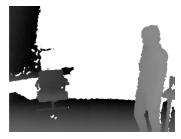

In [19]:
show_image(imageData[0]), show_image(depthData[0])

## Setting Up Learner

Custom Fastai ImageList to support rgb-d images.

In [21]:
class ImageListRGBD(ImageList):
    def open(self, i):
        rgb = imageData[i].type(torch.FloatTensor)
        rgbd = torch.cat((rgb,depthData[i]),0)
        return Image(rgbd)

### Seperate Train, Validation, and Test Sets 

In [22]:
def Diff(li1, li2):
    """
    func: Remove a list of entries from a given list
    param: l1 - a list of items
           l2 - a list of items to be removed from l1
    out: A list of the remaining items in l1       
    """
    return (list(set(li1) - set(li2)))

In [69]:
items = list(range(len(imageData)))
test = random.sample(items,587)
items = Diff(items,test)
val = random.sample(items,1056)
train = Diff(items, val)

Train, validation, and test set sizes.

In [70]:
# Split data into train and valid
print("train: %i" %len(train))
print("validation: %i"%len(val))
print("test: %i"%len(test))

train: 4222
validation: 1056
test: 587


### Create Databunch For Learner

In [71]:
images = ImageListRGBD(items)
images = images.split_by_rand_pct() #Fastai's quirk, image list needs to be initiated and split to assign train and valid

images.train = ImageListRGBD(train)
images.valid = ImageListRGBD(val)

func = lambda i:data_dict["labels"][i]
images = images.label_from_func(func)

### Create Image List With Test Set

Fastai does not support labeled test set. In order to get statistics on model accuracy, we must create a databunch with the test set instead of the validation set and validate the model on the test set. The training set is repeated here because Fastai does not support initiating a databunch without a training set.

In [73]:
test_set = ImageListRGBD(items)
test_set = test_set.split_by_rand_pct() 

test_set.train = ImageListRGBD(train)
test_set.valid = ImageListRGBD(test)

# label test
func = lambda i:data_dict["labels"][i]
test_set = test_set.label_from_func(func)

### Create Databunches

In [74]:
tfms = None #get_transforms(max_rotate=25)# or tfms=None if none are needed
size=224 # size=(224,224) or (400,224)
data = images.transform(tfms,size=224).databunch().normalize()
test_data = test_set.transform(tfms,size=224).databunch().normalize()

In [77]:
data.classes

['carry',
 'clapHands',
 'pickUp',
 'pull',
 'push',
 'sitDown',
 'standUp',
 'throw',
 'walk',
 'waveHands']

In [78]:
data.batch_size = 64

## Learner

Modified resnet model to accept 4 channel image

In [98]:
input_channel = 4
resnet = models.resnet34 ()
resnet.conv1 = torch.nn.Conv2d (input_channel, 64, kernel_size = (7, 7), stride = (1, 1), padding = (3, 3), bias = False)
resnet.avgpool = nn.AdaptiveAvgPool2d ((1, 1))
resnet.fc = torch.nn.Linear(512, len(data.classes), bias=True)

### First Attempt

Training 10 cycles

In [99]:
learn = cnn_learner (data, lambda x: resnet, metrics = accuracy)
# Unfreeze lower layers of model
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


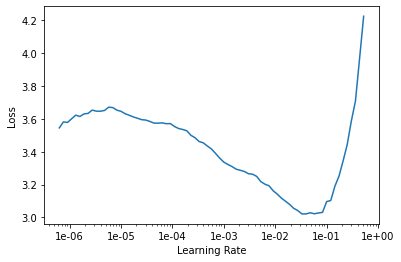

In [85]:
# Test Different learning rates
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12,slice(1e-03,1e-02))
learn.save("stage-1")
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,2.354222,3.004251,0.365530,19:16
1,1.542971,9.857353,0.264205,19:10
2,1.093898,2.482328,0.522727,19:18
3,0.867179,3.316627,0.407197,19:22
4,0.654257,5.168096,0.448864,19:34
5,0.495990,3.077600,0.579545,19:41
6,0.343785,1.541191,0.629735,19:41
7,0.238493,0.232059,0.914773,19:32
8,0.149308,0.192802,0.933712,20:18
9,0.082884,0.112211,0.957386,19:54


### Second Attempt

Reset learner, and train 20 cycles.

In [ ]:
input_channel = 4
resnet = models.resnet34 ()
resnet.conv1 = torch.nn.Conv2d (input_channel, 64, kernel_size = (7, 7), stride = (1, 1), padding = (3, 3), bias = False)
resnet.avgpool = nn.AdaptiveAvgPool2d ((1, 1))
resnet.fc = torch.nn.Linear(512, len(data.classes), bias=True)

In [ ]:
learn = cnn_learner (data, lambda x: resnet, metrics = accuracy)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(20,slice(1e-04,1e-03))
learn.save("stage-2")
learn.recorder.plot_losses()

### Third Attempt

Reset learner, and train 30 cycles.

In [ ]:
input_channel = 4
resnet = models.resnet34 ()
resnet.conv1 = torch.nn.Conv2d (input_channel, 64, kernel_size = (7, 7), stride = (1, 1), padding = (3, 3), bias = False)
resnet.avgpool = nn.AdaptiveAvgPool2d ((1, 1))
resnet.fc = torch.nn.Linear(512, len(data.classes), bias=True)

In [ ]:
learn = cnn_learner (data, lambda x: resnet, metrics = accuracy)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(30,slice(1e-04,1e-03))
learn.save("stage-3")
learn.recorder.plot_losses()

## Results

In [ ]:
learn.validate(test_data.valid)